In [1]:
!pip install --upgrade -q git+https://github.com/MaxHalford/xam 
!pip install --upgrade -q optuna==1.4.0

In [2]:
train_path = "../input/house-prices-advanced-regression-techniques/train.csv"
test_path = "../input/house-prices-advanced-regression-techniques/test.csv"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pickle
%matplotlib inline

In [4]:
X = pd.read_csv(train_path, index_col='Id')
X_test_full = pd.read_csv(test_path, index_col='Id')
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
features = X.drop(columns=['SalePrice'])
target = X['SalePrice']

print(f'data type value count\n{X.dtypes.value_counts()}')
num_cols = features.select_dtypes(exclude=['object']).columns
cat_cols = features.select_dtypes(include=['object']).columns

data type value count
object     43
int64      34
float64     3
dtype: int64


In [6]:
# seperate features by type according to data description
ordinal = ['OverallQual', 'OverallCond']
nominal = list(set(['MSSubClass'] + list(cat_cols)) - set(ordinal))
numeric = list(set(num_cols) - set(ordinal) - set(nominal))

In [7]:
def plot_na_count(features, title='NA count', figsize=(9,6), palette='Paired'):
    na_count = features.isna().sum()
    na_count = (na_count[na_count > 0] / na_count.sum()).sort_values(ascending=False)
    plt.figure(figsize=figsize)
    sns.barplot(x=na_count.index, y=na_count, palette=palette)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.ylabel('proportion of count')
    plt.xlabel('column name')
    plt.show()

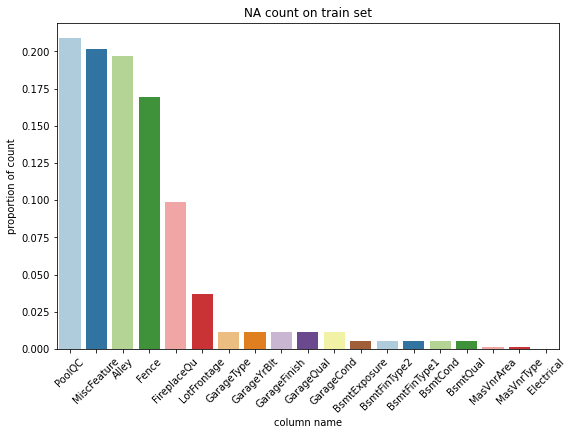

In [8]:
plot_na_count(features, title='NA count on train set')

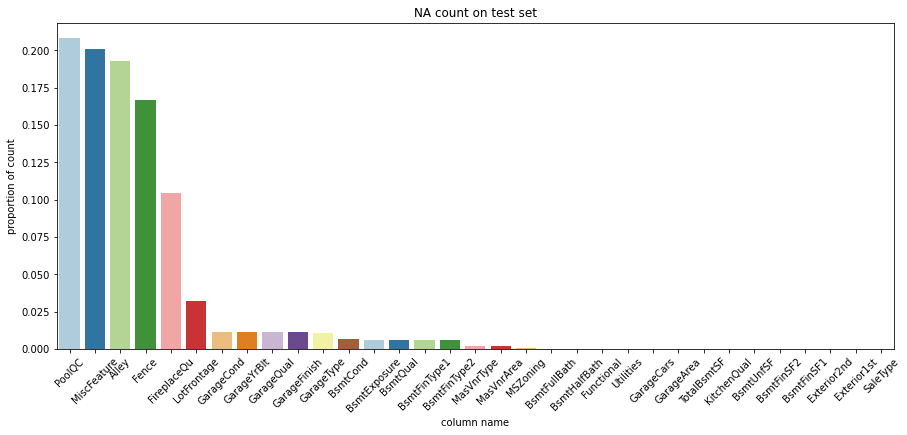

In [9]:
plot_na_count(X_test_full, figsize=(15,6), title='NA count on test set')

In [10]:
none_list = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', \
             'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', \
             'BsmtQual', 'MasVnrType']
street_med_list = ['LotFrontage']
zero_list =  ['MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 'TotalBsmtSF', 'BsmtFinSF2', 'BsmtFinSF1', 'GarageCars', 'GarageArea', 'BsmtUnfSF']
mode_list = ['Electrical', 'MSZoning', 'Functional', 'Utilities', 'KitchenQual', 'Exterior1st', 'Exterior2nd']

# fill empty value according to data description
features.fillna({col: 'None' for col in none_list}, inplace=True)
X_test_full.fillna({col: 'None' for col in none_list}, inplace=True)

features.fillna({col: 0 for col in zero_list}, inplace=True)
X_test_full.fillna({col: 0 for col in zero_list}, inplace=True)

# filling with mode due to unprovided missing value description
features.fillna({col: features[col].mode()[0] for col in mode_list}, inplace=True)
X_test_full.fillna({col: X_test_full[col].mode()[0] for col in mode_list}, inplace=True)

# make missing Sale type = Other
features['SaleType']  = features['SaleType'].fillna('Oth')
X_test_full['SaleType'] = X_test_full['SaleType'].fillna('Oth')

# unlikely to help
features.drop(columns=['GarageYrBlt'], inplace=True)
X_test_full.drop(columns=['GarageYrBlt'], inplace=True)
numeric.remove('GarageYrBlt')

log_target = np.log1p(target) # log transform target for ease of evaluation

skewness of lot frontage: 2.163569142324884 



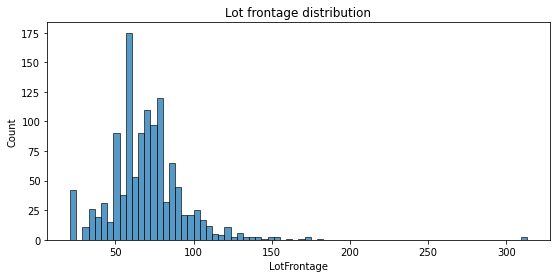

In [11]:
print('skewness of lot frontage:', features['LotFrontage'].skew(), '\n')
plt.figure(figsize=(9,4))
plt.title('Lot frontage distribution')
sns.histplot(features['LotFrontage'])
plt.show()

In [12]:
# filling with median due to unprovided missing value description and non-normality of column
features['LotFrontage'] = features.groupby('Street')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
X_test_full['LotFrontage'] = X_test_full.groupby('Street')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

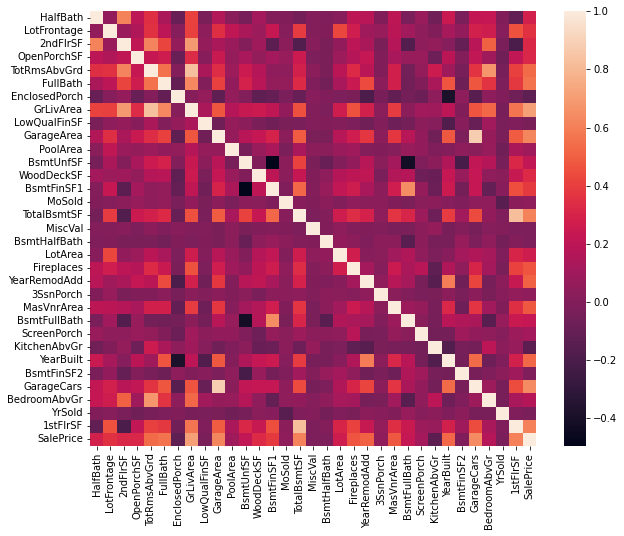

In [13]:
# plot correlation heat map
corr = X[numeric + ['SalePrice']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr)
plt.show()

In [14]:
copy = features[numeric].copy()
copy_t = X_test_full[numeric].copy()

# drop highly correlated features
copy.drop(columns=['2ndFlrSF', 'GarageCars', '1stFlrSF', 'BsmtFullBath'], inplace=True)
copy_t.drop(columns=['2ndFlrSF', 'GarageCars', '1stFlrSF', 'BsmtFullBath'], inplace=True)

copy.columns

Index(['HalfBath', 'LotFrontage', 'OpenPorchSF', 'TotRmsAbvGrd', 'FullBath',
       'EnclosedPorch', 'GrLivArea', 'LowQualFinSF', 'GarageArea', 'PoolArea',
       'BsmtUnfSF', 'WoodDeckSF', 'BsmtFinSF1', 'MoSold', 'TotalBsmtSF',
       'MiscVal', 'BsmtHalfBath', 'LotArea', 'Fireplaces', 'YearRemodAdd',
       '3SsnPorch', 'MasVnrArea', 'ScreenPorch', 'KitchenAbvGr', 'YearBuilt',
       'BsmtFinSF2', 'BedroomAbvGr', 'YrSold'],
      dtype='object')

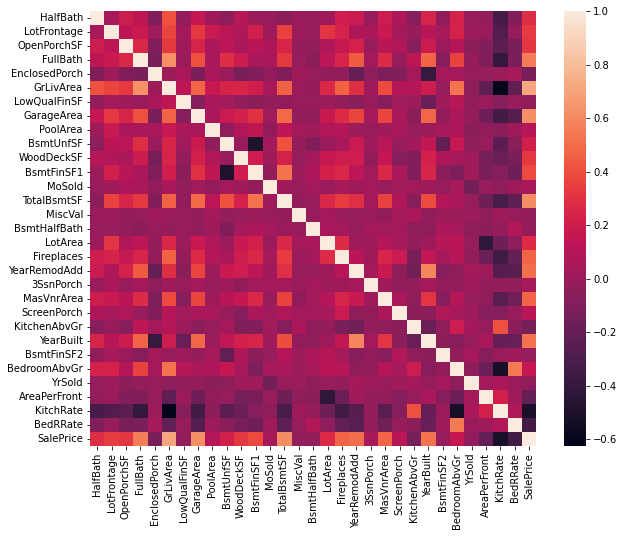

In [15]:
copy['AreaPerFront'] = copy['LotFrontage'] / copy['LotArea']
copy_t['AreaPerFront'] = copy_t['LotFrontage'] / copy_t['LotArea']

copy['KitchRate'] = copy['KitchenAbvGr'] / copy['TotRmsAbvGrd']
copy_t['KitchRate'] = copy_t['KitchenAbvGr'] / copy_t['TotRmsAbvGrd']

copy['BedRRate'] = copy['BedroomAbvGr'] / copy['TotRmsAbvGrd']
copy_t['BedRRate'] = copy_t['BedroomAbvGr'] / copy_t['TotRmsAbvGrd']

# copy['BsmtFinSF'] = copy['BsmtFinSF1'] + copy['BsmtFinSF2']
# copy_t['BsmtFinSF'] = copy_t['BsmtFinSF1'] + copy_t['BsmtFinSF2']

# copy['FullBathRate'] = copy['FullBath'] / copy['GrLivArea']
# copy_t['FullBathRate'] = copy_t['FullBath'] / copy_t['GrLivArea']

# copy['PorchSF'] = copy['OpenPorchSF'] + copy['EnclosedPorch'] + copy['3SsnPorch'] + copy['ScreenPorch']
# copy_t['PorchSF'] = copy_t['OpenPorchSF'] + copy_t['EnclosedPorch'] + copy_t['3SsnPorch'] + copy_t['ScreenPorch']

copy.drop(columns=['TotRmsAbvGrd'], inplace=True)
copy_t.drop(columns=['TotRmsAbvGrd'], inplace=True)

plt.figure(figsize=(10,8))
sns.heatmap(pd.concat([copy, X['SalePrice']], axis=1).corr())
plt.show()

In [16]:
(np.abs(copy.corr()) >= 0.7).sum() # verify no colinearity

HalfBath         1
LotFrontage      1
OpenPorchSF      1
FullBath         1
EnclosedPorch    1
GrLivArea        1
LowQualFinSF     1
GarageArea       1
PoolArea         1
BsmtUnfSF        1
WoodDeckSF       1
BsmtFinSF1       1
MoSold           1
TotalBsmtSF      1
MiscVal          1
BsmtHalfBath     1
LotArea          1
Fireplaces       1
YearRemodAdd     1
3SsnPorch        1
MasVnrArea       1
ScreenPorch      1
KitchenAbvGr     1
YearBuilt        1
BsmtFinSF2       1
BedroomAbvGr     1
YrSold           1
AreaPerFront     1
KitchRate        1
BedRRate         1
dtype: int64

In [17]:
from xam.feature_extraction import BayesianTargetEncoder

# encode categorical variable using target group mean
enc = BayesianTargetEncoder(
    columns=nominal,
    prior_weight=5, # smoothing to prevent overfitting
    suffix=''
    )

nom_train = enc.fit_transform(features.loc[:,nominal], log_target)
nom_test = enc.transform(X_test_full.loc[:,nominal])

In [18]:
copy_cat = pd.concat([features[ordinal], nom_train], axis=1)
copy_catt = pd.concat([X_test_full[ordinal], nom_test], axis=1)

In [19]:
from sklearn.preprocessing import StandardScaler
# feature standardization
scaler = StandardScaler()
num_scaled = pd.DataFrame(scaler.fit_transform(copy), index=features.index, columns=copy.columns)
num_scaled_test = pd.DataFrame(scaler.transform(copy_t), index=X_test_full.index, columns=copy.columns)

scaler_cat = StandardScaler()
cat_scaled = pd.DataFrame(scaler.fit_transform(copy_cat), index=features.index, columns=copy_cat.columns)
cat_scaled_test = pd.DataFrame(scaler.transform(copy_catt), index=X_test_full.index, columns=copy_catt.columns)

In [20]:
X_train = pd.concat([num_scaled, copy_cat], axis=1)
X_test = pd.concat([num_scaled_test, copy_catt], axis=1)

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
n_splits = 3
def do_cv(X, y, clf):
    means = []
    kf = KFold(n_splits=n_splits, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = clf.fit(X_train, y_train)
        rmsle = mean_squared_error(y_test, model.predict(X_test), squared=False)
        means.append(rmsle)
    return np.average(means)

In [22]:
import optuna
from sklearn.linear_model import Lasso, Ridge

def objective_lasso(trial):
    params = dict(
           alpha=trial.suggest_float('alpha', 1e-6, 1e1)
    )
    model = Lasso(**params, max_iter = 10000000)
    return do_cv(X_train, log_target, model)

optuna.logging.set_verbosity(optuna.logging.ERROR)
study_lasso = optuna.create_study(direction='minimize')
study_lasso.optimize(objective_lasso, n_trials=150, show_progress_bar=True)

/opt/conda/lib/python3.7/site-packages/optuna/_experimental.py:90: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  ExperimentalWarning,


  0%|          | 0/150 [00:00<?, ?it/s]

In [23]:
print('best lasso regression rmsle score:', study_lasso.best_value)
optuna.visualization.plot_optimization_history(study_lasso)

best lasso regression rmsle score: 0.14321306339898346


In [24]:
lasso_model = Lasso(**study_lasso.best_params).fit(X_train, log_target)
np.expm1(lasso_model.predict(X_test))

array([120269.37970816, 149138.07523963, 176897.60882858, ...,
       170758.33634219, 119807.61287172, 214919.64266919])

In [25]:
def objective_ridge(trial):
    params = dict(
           alpha=trial.suggest_float('alpha', 1e-4, 1e2)
    )
    model = Ridge(**params, max_iter = 10000000)
    return do_cv(X_train, log_target, model)

optuna.logging.set_verbosity(optuna.logging.ERROR)
study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge, n_trials=150, show_progress_bar=True)

/opt/conda/lib/python3.7/site-packages/optuna/_experimental.py:90: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/150 [00:00<?, ?it/s]

In [26]:
print('best ridge regression rmsle score:', study_ridge.best_value)
optuna.visualization.plot_optimization_history(study_ridge)

best ridge regression rmsle score: 0.1398182601829086


In [27]:
ridge_model = Ridge(**study_ridge.best_params).fit(X_train, log_target)
np.expm1(ridge_model.predict(X_test))

array([120314.50091061, 149570.66063402, 176232.14145148, ...,
       171405.20762079, 119269.96967865, 216174.93928639])

In [28]:
from sklearn.svm import SVR

def objective_svr(trial):
    params = dict(
            C=trial.suggest_float('C', 1e-3, 1e3)
    )
    model = SVR(**params)
    return do_cv(X_train, log_target, model)

optuna.logging.set_verbosity(optuna.logging.ERROR)
study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(objective_svr, n_trials=150, show_progress_bar=True)

/opt/conda/lib/python3.7/site-packages/optuna/_experimental.py:90: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/150 [00:00<?, ?it/s]

In [29]:
print('best svr rmsle score:', study_svr.best_value)
optuna.visualization.plot_optimization_history(study_svr)

best svr rmsle score: 0.12520698309139316


In [30]:
svr_model = SVR(**study_svr.best_params).fit(X_train, log_target)
np.expm1(svr_model.predict(X_test))

array([117319.27918307, 157936.56297801, 184511.10008464, ...,
       169446.44759314, 114479.29672604, 222521.26277922])

In [31]:
from sklearn.neighbors import KNeighborsRegressor
def objective_knn(trial):
    params = dict(
        n_neighbors=trial.suggest_int('n_neighbors', 2, 15),
        weights=trial.suggest_categorical('weights', ['uniform', 'distance'])
    )
    model = KNeighborsRegressor(**params)
    return do_cv(pd.concat([num_scaled, cat_scaled], axis=1), log_target, model)

optuna.logging.set_verbosity(optuna.logging.ERROR)
study_knn = optuna.create_study(direction='minimize')
study_knn.optimize(objective_knn, n_trials=150, show_progress_bar=True)

/opt/conda/lib/python3.7/site-packages/optuna/_experimental.py:90: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/150 [00:00<?, ?it/s]

In [32]:
print('best knn rmsle score:', study_knn.best_value)
optuna.visualization.plot_optimization_history(study_knn)

best knn rmsle score: 0.18120022842462782


In [33]:
knn_model = KNeighborsRegressor(**study_knn.best_params).fit(pd.concat([num_scaled, cat_scaled], axis=1), log_target)
np.expm1(knn_model.predict(pd.concat([num_scaled_test, cat_scaled_test], axis=1)))

array([123507.03828924, 164655.94664082, 194787.75028624, ...,
       155503.56994376, 109466.49312707, 203549.48180368])

In [34]:
stacked = 0.8 * svr_model.predict(X_test) + 0.2 * ridge_model.predict(X_test)
np.expm1(stacked)

array([117912.29808253, 156226.76114066, 182824.76449429, ...,
       169836.40064876, 115421.78449544, 221237.26550178])

In [35]:
# export models
with open('svr.pkl', 'wb') as fp:
    pickle.dump(svr_model, fp)
    
with open('ridge.pkl', 'wb') as fp:
    pickle.dump(ridge_model, fp)